# Trabalho 1 - Visualização Computacional

- Prof. Ricardo Marcondes Marcacini
- Monitor PAE: Ângelo César Mendes da Silva

##Objetivos
Análise exploratória usando técnicas de visualização computacional de uma base de dados utilizando as técnicas estudadas até a Aula 06.

## Feito por
- Caio Augusto Duarte Basso
- Gabriel Garcia Lorencetti

## Vídeo
https://youtu.be/fT7YgK1SvMI

### Requisitos do trabalho:
1. A base de dados deve possuir no mínimo 1000 instâncias e 10 atributos.
2. A base de dados deve possuir atributos categóricos e ordinais/numéricos.
3. Aplique o pré-processamento que considerar adequado e justifique.
4. Escolha os top-5 atributos para análise via scatter-plot.
5. Aplique cluster nos dados e utilize as informações de cluster juntamente com
coordenadas paralelas (para colorir a visualização)
6. Aplique também coordenadas paralelas considerando apenas os dados categóricos.
7. Construa uma rede k-nn (KNNG) e analise a base de dados. Pode utilizar os
clusters gerados para apoiar a análise.
8. Crie uma mapa bidimensional por meio de Redes SOM. Explique os resultados que
obteve.
9. Realize uma projeção via PCA utilizando os atributos ordinais/numéricos. Mostre as
duas componentes principais e avalie.

### Importando as bibliotecas

In [ ]:
!pip install minisom

  Using cached MiniSom-2.2.9-py3-none-any.whl


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

### Importando o dataset

Segundo a OMS (Organização Mundial da Saúde), o AVC é a 2ª maior causa de morte no mundo, sendo responsável por aproximadamente 11% de mortes mundiais.

Este conjunto de dados (disponível [neste link](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv)) é usado para prever se um paciente tem probabilidade de desenvolver AVC com base nos parâmetros de entrada como sexo, idade, várias doenças e tabagismo. Cada linha dos dados fornece informações relevantes sobre o paciente.

**Descrição dos atributos:**
1. **id**: identificador único
2. **gender** (gênero): "Male" (Masculino), "Female" (Feminino) ou "Other" (Outro)
3. **age** (idade): idade do paciente
4. **hypertension** (hipertensão): 0 se o paciente não tem hipertensão, 1 se o paciente tem hipertensão
5. **heart_disease** (doença cardíaca): 0 se o paciente não tem doenças cardíacas, 1 se o paciente tem doença cardíaca
6. **ever_married** (alguma vez casado): "No" (Não) ou "Yes" (Sim)
7. **work_type** (tipo de trabalho): "children" (criança), "Govt_jov" (emprego governamental), "Never_worked" (nunca trabalhou), "Private" (privado) ou "Self-employed" (autônomo)
8. **Residence_type** (tipo de residência): "Rural" (rural) ou "Urban" (urbana)
9. **avg_glucose_level** (nível médio de glicose): nível médio de glicose no sangue
10. **bmi** (IMC): índice de massa corporal
11. **smoking_status** (condição de fumante): "formerly smoked" (que ja tenha fumado, mas parou), "never smoked" (que nunca fumou), "smokes" (que fuma) ou "Unknown" (informação desconhecida)
12. **stroke** (AVC): 1 se o paciente teve um AVC ou 0 se não

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


###Pré processamento na base de dados
Há alguns dados NaN (principalmente na coluna de bmi (Índice de Massa Corporal)), então, por considerarmos um atributo importante para a observação de AVC's, iremos descartar as instâcias com valores ausentes.

In [ ]:
df = df.dropna()

Também, a coluna de identificador único não nos será útil para a análise que será feita, sendo assim, iremos excluí-la do nosso banco de dados.

In [ ]:
df = df.drop(columns=['id'])

Além disso, transformaremos alguns atributos nominais em atributos discretos, para auxiliar alguns dos métodos que serão utilizados (que trabalham melhor com números).

In [ ]:
gender = {'Male': 0, 'Female': 1, 'Other': 2}
df['gender_b'] = [gender[item] for item in  df.gender]

ever_married = {'No': 0, 'Yes': 1}
df['ever_married_b'] = [ever_married[item] for item in df.ever_married]

work_type = {'children': 0, 'Govt_job': 1, 'Never_worked': 2, 'Private': 3, 'Self-employed': 4}
df['work_type_b'] = [work_type[item] for item in df.work_type]

Residence_type = {'Rural': 0, 'Urban': 1}
df['Residence_type_b'] = [Residence_type[item] for item in df.Residence_type]

smoking_status = {'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': -1}
df['smoking_status_b'] = [smoking_status[item] for item in df.smoking_status]

df = df[['gender', 'gender_b',	'age',	'hypertension',	'heart_disease',	'ever_married', 'ever_married_b',	'work_type',	'work_type_b', 'Residence_type', 'Residence_type_b',	'avg_glucose_level',	'bmi',	'smoking_status', 'smoking_status_b', 'stroke']]

In [ ]:
df

,gender,gender_b,age,hypertension,heart_disease,ever_married,ever_married_b,work_type,work_type_b,Residence_type,Residence_type_b,avg_glucose_level,bmi,smoking_status,smoking_status_b,stroke
0,Male,0,67.0,0,1,Yes,1,Private,3,Urban,1,228.69,36.6,formerly smoked,2,1
2,Male,0,80.0,0,1,Yes,1,Private,3,Rural,0,105.92,32.5,never smoked,0,1
3,Female,1,49.0,0,0,Yes,1,Private,3,Urban,1,171.23,34.4,smokes,1,1
4,Female,1,79.0,1,0,Yes,1,Self-employed,4,Rural,0,174.12,24.0,never smoked,0,1
5,Male,0,81.0,0,0,Yes,1,Private,3,Urban,1,186.21,29.0,formerly smoked,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,1,13.0,0,0,No,0,children,0,Rural,0,103.08,18.6,Unknown,-1,0
5106,Female,1,81.0,0,0,Yes,1,Self-employed,4,Urban,1,125.20,40.0,never smoked,0,0
5107,Female,1,35.0,0,0,Yes,1,Self-employed,4,Rural,0,82.99,30.6,never smoked,0,0
5108,Male,0,51.0,0,0,Yes,1,Private,3,Rural,0,166.29,25.6,formerly smoked,2,0


Decidiu-se, nesse momento, não normalizar os dados, já que grande parte dos atributos são discretos, e não contíuos.

### Correlação entre atributos
A correlação entre atributos mede o relacionamento linear entre os atributos, e pode nos auxiliar na escolha dos top-5 atributos para a análise via scatter plot.
- os valores próximos de 1 indicam que são positivamente dependentes;
- os valores próximos de -1 indicam que são negativamente dependentes;
- e os valores próximos de 0 indicam a não dependência entre atributos.

In [ ]:
df.corr()

,gender_b,age,hypertension,heart_disease,ever_married_b,work_type_b,Residence_type_b,avg_glucose_level,bmi,smoking_status_b,stroke
gender_b,1.000000,0.029817,-0.021978,-0.083014,0.035543,0.073052,0.003755,-0.052613,0.025658,-0.005540,-0.007021
age,0.029817,1.000000,0.274425,0.257123,0.680782,0.538124,0.010948,0.235838,0.333398,0.370804,0.232331
hypertension,-0.021978,0.274425,1.000000,0.115991,0.162406,0.124655,-0.001074,0.180543,0.167811,0.116909,0.142515
heart_disease,-0.083014,0.257123,0.115991,1.000000,0.111245,0.092145,-0.002362,0.154525,0.041357,0.100412,0.137938
ever_married_b,0.035543,0.680782,0.162406,0.111245,1.000000,0.425914,0.004989,0.151377,0.341695,0.310781,0.105089
work_type_b,0.073052,0.538124,0.124655,0.092145,0.425914,1.000000,-0.000883,0.092490,0.341434,0.315359,0.079745
Residence_type_b,0.003755,0.010948,-0.001074,-0.002362,0.004989,-0.000883,1.000000,-0.007617,-0.000122,0.017607,0.006031
avg_glucose_level,-0.052613,0.235838,0.180543,0.154525,0.151377,0.092490,-0.007617,1.000000,0.175502,0.102249,0.138936
bmi,0.025658,0.333398,0.167811,0.041357,0.341695,0.341434,-0.000122,0.175502,1.000000,0.225345,0.042374
smoking_status_b,-0.005540,0.370804,0.116909,0.100412,0.310781,0.315359,0.017607,0.102249,0.225345,1.000000,0.081336


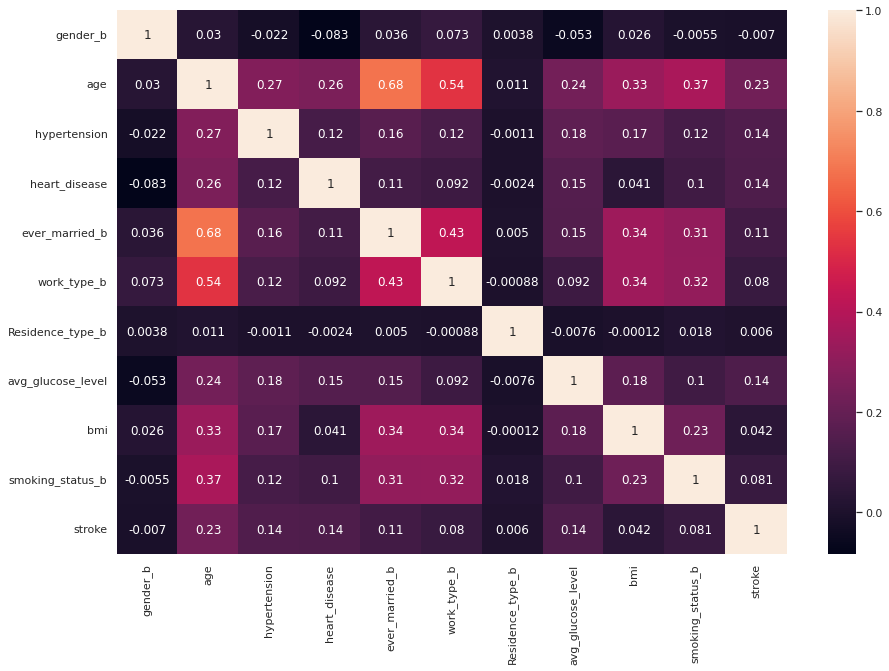

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df.corr(), annot = True)

Observando o atributo stroke (AVC), os atributos que mais se correlacionam com ele são:
- age (idade);
- hypertension (hipertensão);
- heart_desease (doença cardíaca);
- ever_married (alguma vez casado);
- e avg_glicose_level (nível médio de glicose).

### Scatter plots
Vamos agora utilizar os scatter plots para visualizar os relacionamentos par a par entre os atributos numéricos do conjunto de dados.

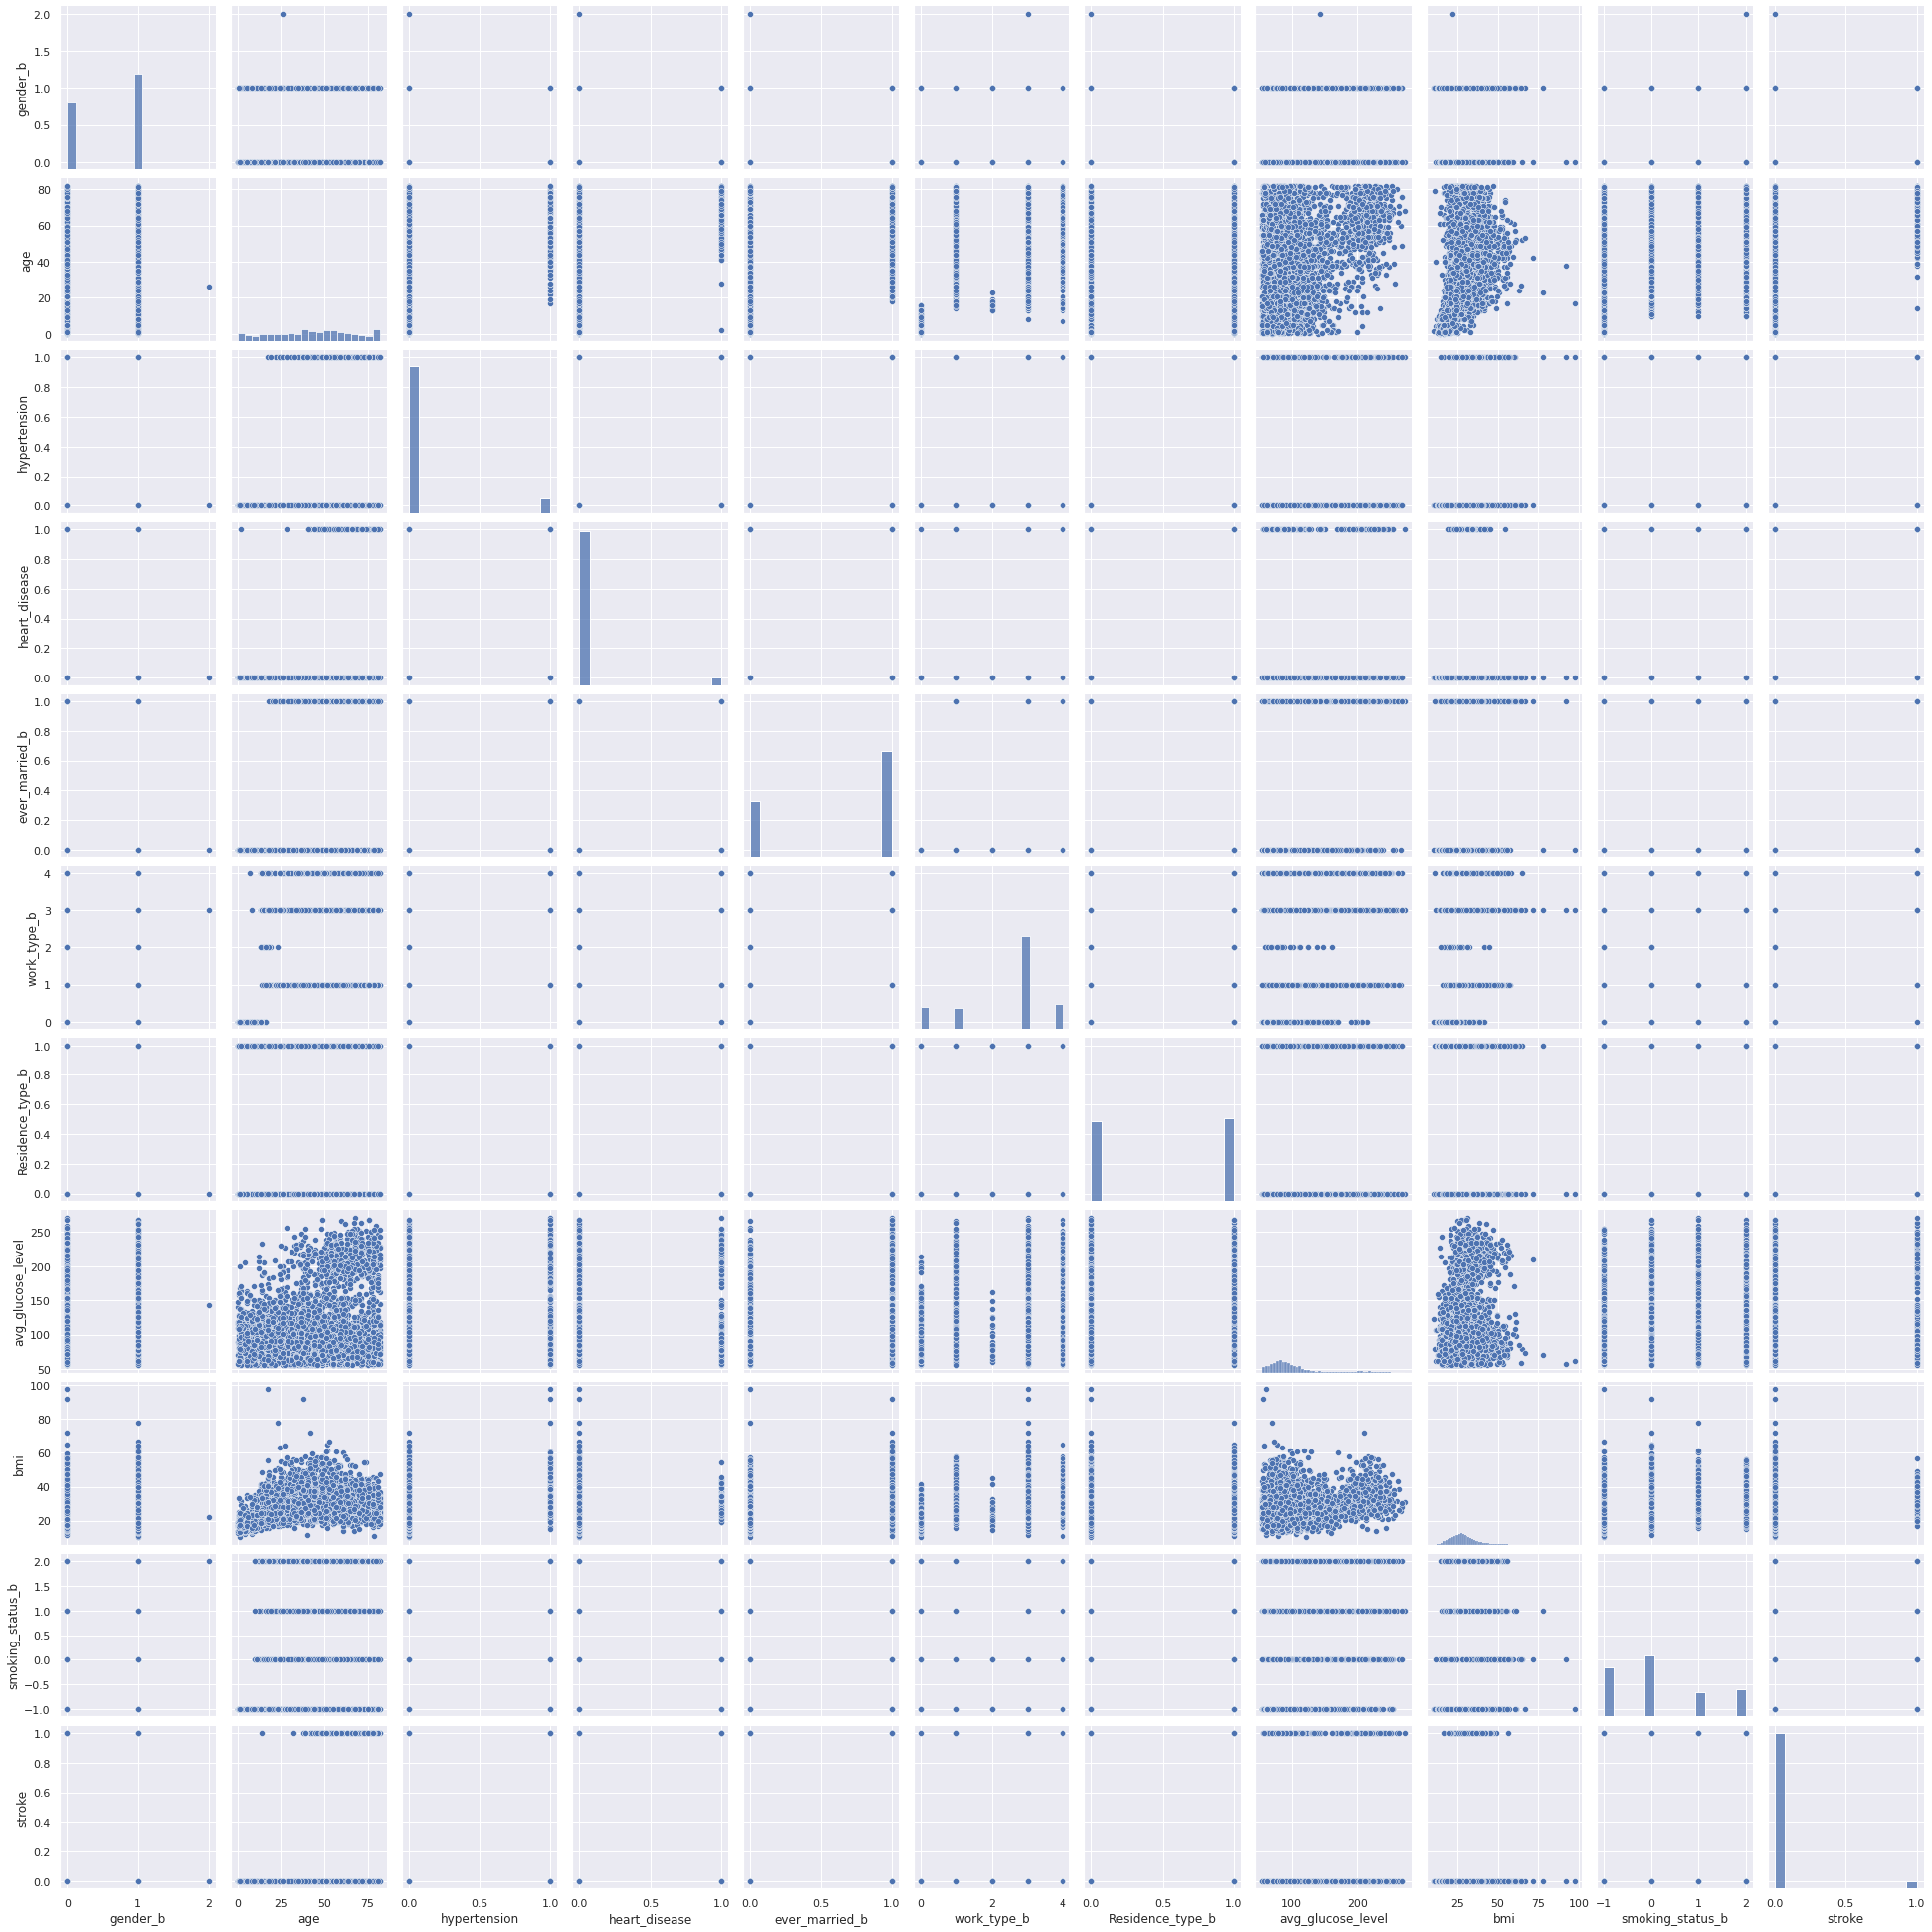

In [ ]:
sns.pairplot(df)

Como é possível observar, o dataset possui muitos atributos, sendo de difícil observação com o scatter plot. Para melhorar isso, escolhemos os 5 atributos com maior correlação com o AVC, sendo eles: idade, hipertensão, doença cardíaca, alguma vez casado e nível de glicose no sangue.

In [ ]:
scatter_df = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married_b', 'stroke']]

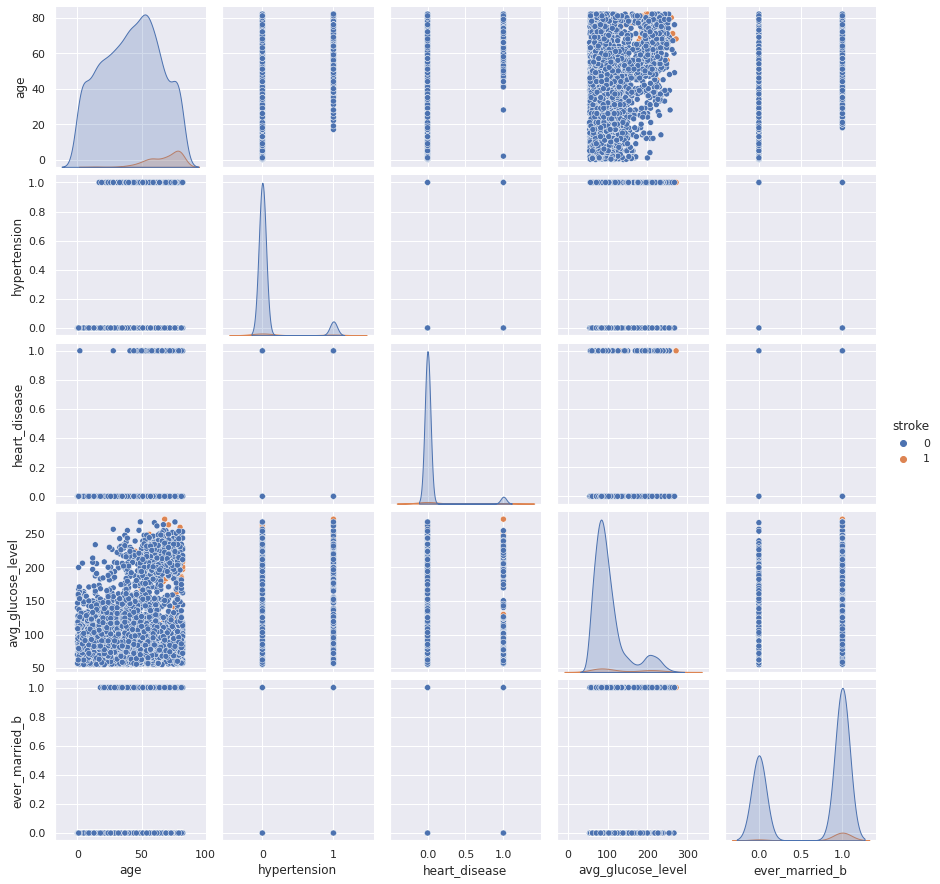

In [ ]:
g = sns.pairplot(
    scatter_df, 
    hue='stroke')

# g.fig.set_size_inches(20,20)

Vamos observar mais de perto alguns plots que chamaram mais atenção.

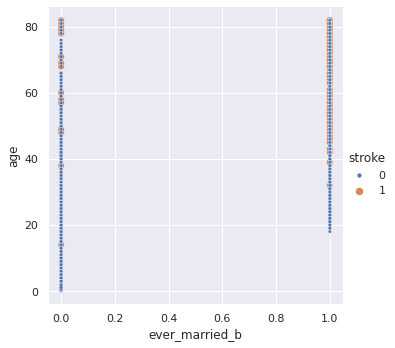

In [ ]:
sns.relplot(x="ever_married_b", y="age", size="stroke", sizes={0: 10, 1: 40}, hue="stroke", data=scatter_df)

Aqui, podemos ver uma curiosa relação entre alguma vez casado e AVC. A partir de, mais ou menos os 40 anos, a quantidade de AVC's entre aqueles que já foram casados aparenta ser bem maior que daqueles que nunca se casaram.

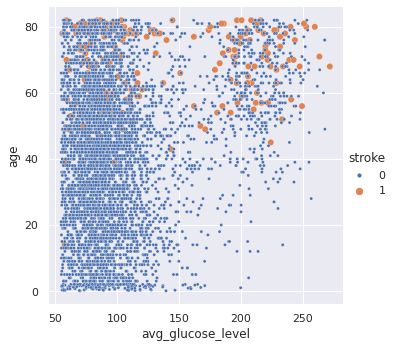

In [ ]:
sns.relplot(y="age", x="avg_glucose_level", size="stroke", sizes={0: 10, 1: 40}, hue="stroke", data=scatter_df)

Aqui, podemos observar uma maior concentração de pessoas com nível de glicose entre 50 e 150. Mais uma vez, é possível notar a prevalência de AVC's nas pessoas acima de 40 anos. Porém, nota-se que, mesmo com a quantidade menor de pessoas com nível de glicose acima de 150 é menor, a quantidade de pessoas que tiveram AVC é maior. Ou seja, é possível afirmar a relação entre o maior nível de glicose e AVC's.

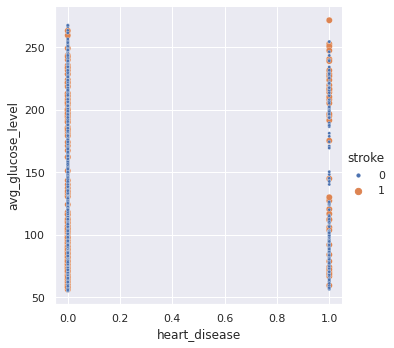

In [ ]:
sns.relplot(x="heart_disease", y="avg_glucose_level", size="stroke", sizes={0: 10, 1: 40}, hue="stroke", data=scatter_df)

Aqui, não foi possível observar uma relação tão direta entre doença cardíaca e nível de glicose na presença de AVC.

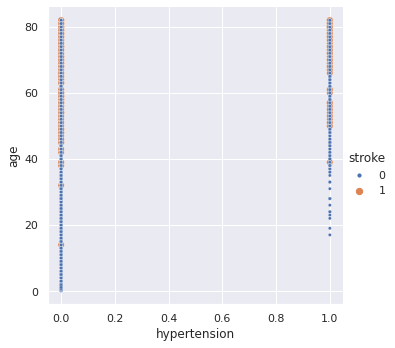

In [ ]:
sns.relplot(x="hypertension", y="age", size="stroke", sizes={0: 10, 1: 40}, hue="stroke", data=scatter_df)

Aqui também, não foi possível observar uma relação tão direta entre hipertensão e idade na presença de AVC.

### Clusterização e análise com coordenadas paralelas
Agora iremos utilizar o algoritmo k-Means para particionar os dados em k grupos (em nosso caso, em 5).

In [ ]:
kmeans = KMeans(n_clusters=5,n_init=10,init='random',max_iter=300)
kmeans.fit(scatter_df)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [ ]:
df['cluster'] = kmeans.labels_

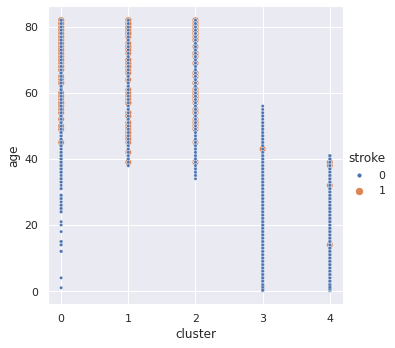

In [ ]:
sns.relplot(x="cluster", y="age", size="stroke", sizes={0: 10, 1: 40}, hue="stroke", data=df)

Testou-se utilizar de 2 a 7 clusters no algoritmo, mas observamos que o número 5 reproduzia um resultado satisfatório. 

Nele, como é possível observar no gráfico acima, 3 clusters englobavam pessoas com mais de 40 anos com probabilidade de AVC's, um cluster com pessoas com menos de 60 anos com quase nenhuma chance de AVC (somente uma pessoa nesse cluster teve AVC) e um cluster com pessoas de menos de 40 anos com alguma probabilidade de AVC.

In [ ]:
df_small = df[['stroke', 'age',	'hypertension',	'avg_glucose_level', 'bmi', 'heart_disease', 'cluster']]
px.parallel_coordinates(df_small, color="cluster")

Aqui na representação paralela (colorida com os clusters calculados acima) podemos ver algumas relações interessantes entre os atributos numéricos. Observa-se que a grande maioria das pessoas que tiveram AVC possuem uma idade acima dos 40 anos. Também, a maioria das pessoas com hipertensão também possuem mais de 40 anos. Outra relação interessante é que, grande parte dos que possuem doenças cardíacas, tem um IMC entre 25 e 40 (faixa correspondente a sobrepeso e obesidade). Ademais, outros atributos não parecem possuir muita correlação uns com os outros, dado que há uma divisão muito grande nos resultados vindos da mesma faixa do dado.

In [ ]:
df_cat = df[['stroke', 'hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type', 'gender', 'smoking_status', 'cluster']]
px.parallel_categories(df_cat, color="cluster")

Aqui, somente os dados categóricos estão sendo utilizados para a análise paralela, e logo percebemos algumas relações interessantes entre os dados, como a relação entre hipertensão e doença no coração, onde a correlação entre eles aparenta ser próxima de 1.0.

Organizamos os dados de forma a que a correlação, visualmente, fosse diminuindo. Então, é possível notar que atributos como gender, residence type e smoking status possuem linhas bem "bagunçadas", o que demonstra uma falta de correlação entre esses atributos.

É possível também ver uma relação interessante entre pessoas que nunca trabalharam e outros dados considerados negativos, apesar da base conter apenas 22 pessoas que nunca trabalharam, podemos ver que dentre essas pessoas, nenhuma tem problemas no coração, hipertensão ou fuma.

### Análise com K-nn


In [ ]:
X = df[['gender_b',	'age',	'hypertension',	'heart_disease', 'ever_married_b',	'work_type_b', 'Residence_type_b',	'avg_glucose_level',	'bmi', 'smoking_status_b', 'stroke']]

A = kneighbors_graph(X, n_neighbors=12, metric="manhattan")

A.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
G = nx.Graph(A)

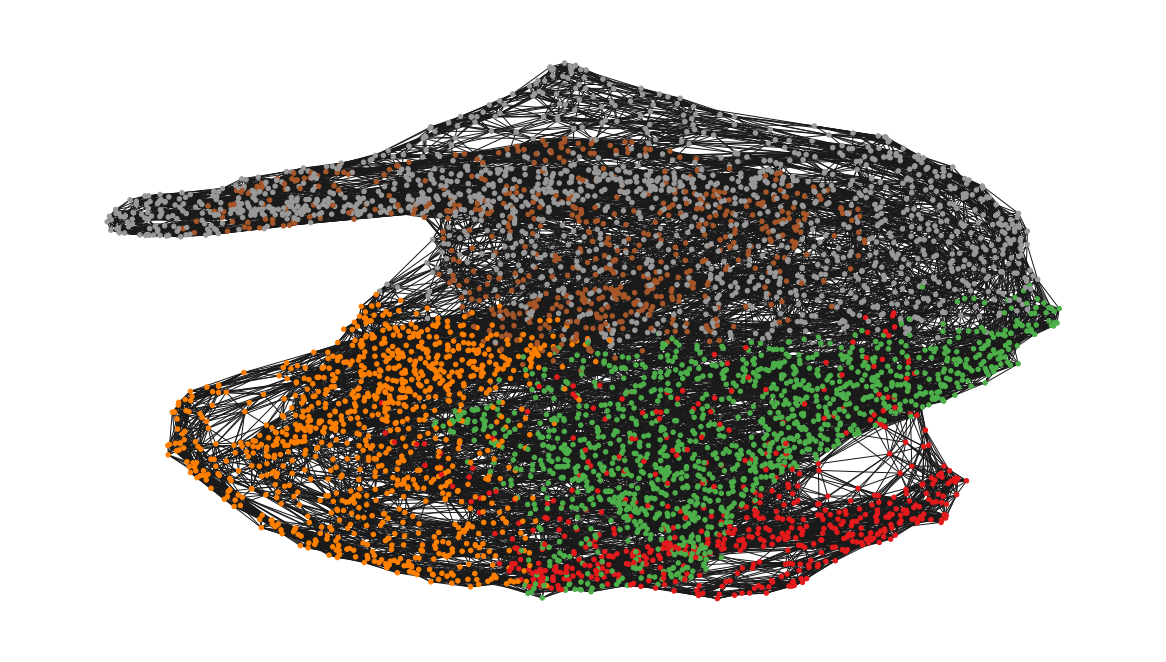

In [ ]:
plt.figure(figsize=(16,9)) 

nx.draw(G, node_size=20, pos=nx.spring_layout(G), node_color=df['cluster'], cmap=plt.cm.Set1)

Aqui, podemos ver que há um cluster bem definidos, e que os outros clusters se sobrepõem. Com isso podemos dizer que dado um caso novo que se encaixa nesse cluster bem definido, podemos assumir com um certo nível de segurança que o resultado do paciente segue o resultado majoritário dentro deste cluster.

### Redes SOM

In [ ]:
df_train = df[['gender_b', 'age',	'hypertension',	'heart_disease', 'ever_married_b',	'work_type_b',  'Residence_type_b',	'avg_glucose_level',	'bmi', 'smoking_status_b', 'stroke']]

In [ ]:
X_train =  df_train.loc[:,'gender_b':'smoking_status_b'].values
y_train = df_train.loc[:, 'stroke'].values

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
label = LabelEncoder()
y_train = label.fit_transform(y_train)

In [ ]:
features = list(df_train)
X_train = df_train.loc[:, features].values

In [ ]:
normal_sc = MinMaxScaler(feature_range = (0,1))
X_train = normal_sc.fit_transform(X_train)

Criando uma rede 15x15, taxa de aprendizado de 0.5 e número de iterações = 25000.

In [ ]:
som = MiniSom(x = 15, y = 15, input_len = 11, sigma = 3.0, learning_rate = 0.5)
som.random_weights_init(X_train)
som.train_random(data = X_train, num_iteration = 25000)

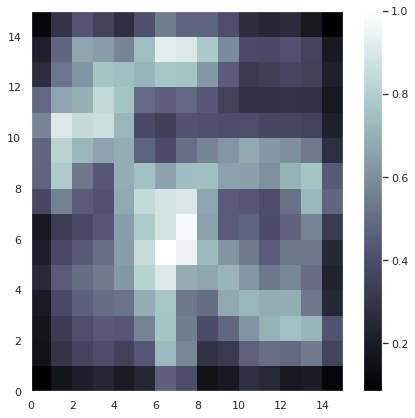

In [ ]:
plt.figure(figsize=(7, 7))
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()

0it [00:00, ?it/s]

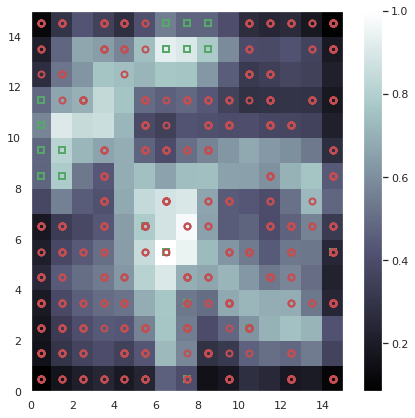

In [ ]:
plt.figure(figsize=(7, 7))
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar()
markers = ['o', 's']
colors = ['r', 'g']

sample = 0

for i, x in tqdm(enumerate(X_train)):
    w = som.winner(x)
    plt.plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y_train[i]],
         markeredgecolor = colors[y_train[i]],
         markerfacecolor = 'None',
         markersize = 6,
         markeredgewidth = 2)
    sample += 1
    if sample >= 1000: break
plt.show()

Aqui podemos ver uma separação entre quem teve e quem não teve AVC. No mapa gerado, é possível notar que as instâncias das pessoas que tiveram AVC (quadrado verde) tendem a ficar em regiões mais claras, enquanto as instâncias das pessoas que não tiveram AVC (círculo vermelho) tendem a ficar em regiões mais escuras, embora acreditemos que mesmo com muitos testes, a rede não conseguiu se especializar tão bem, já que há áreas em que há círculos e quadrados na mesma região sobrepostos.

### Projeção via PCA


#### Projeção sem normalização

In [ ]:
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married_b', 'stroke']
pca = PCA(n_components=3)
components = pca.fit_transform(df[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=df["cluster"]
    )
fig.update_traces(diagonal_visible=False)
fig.show()

A componente principal 1 possui uma taxa de 81%, e comparada com a componente principal 2 (19%) podemos observar uma separação muito boa (comparando com os clusters gerados), armazenando bem, com somente 2 componentes, as informações do dataset.

Já a comparação PC2 vs PC3 (PC3 que, inclusive, possue variabilidade 0), a projeção fica bem mais confusa e menos clara, com os clusters não tão bem separados.

#### Projeção com normalização

In [ ]:
df_norm = df[features]
df_norm=(df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

pca = PCA(n_components=3)
components = pca.fit_transform(df_norm)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=df["cluster"]
    )
fig.update_traces(diagonal_visible=False)
fig.show()

A componente principal 1 possui uma taxa de 53,7%, e comparada com a componente principal 2 (16,7%) já não é possível ver uma separação tão clara como a sem normalização. Entre os componentes 2 e 3 então, os clusters estão bem misturados.

####Avaliação do PCA

Vamos aplicar o k-Means para a os atributos utilizados no PCA:

In [ ]:
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married_b', 'stroke']
X = df[features]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 0, 1, ..., 0, 1, 0], dtype=int32)

Vamos aplicar o PCA duas vezes, uma com os dados sem processamento, e outra normalizando os dados, para ver qual nos dá um resultado melhor. E então, aplicar o k-Means nesses PCA's:

In [ ]:
# sem normalização
X_pca = pca.transform(df[features])
df_pca = pd.DataFrame(X_pca)
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(X_pca)


# com normalização
Norm_pca = pca.transform(df_norm)
df_norm_pca = pd.DataFrame(Norm_pca)
kmeans_norm_pca = KMeans(n_clusters=2, random_state=0).fit(Norm_pca)

k-Means vs resultado

In [ ]:
adjusted_rand_score(kmeans.labels_, df.stroke.to_list())

0.0930549234086609

PCA sem normalização vs resultado

In [ ]:
adjusted_rand_score(kmeans_pca.labels_, df.stroke.to_list())

0.11531504653542031

PCA com normalização vs resultado

In [ ]:
adjusted_rand_score(kmeans_norm_pca.labels_, df.stroke.to_list())

-0.022749624796682154

Aqui podemos perceber que para esta base de dados em particular, não é bom normalizar os dados. Além disso, é possível observar que o PCA alcançou um resultado melhor que só o k-Means.